<a href="https://colab.research.google.com/github/bpazos97/ElMetodoCloudWord/blob/main/El_M%C3%A9todo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **El Método Cloudwords**

This jupyter notebook was created to extract the transcripts of all the chapters of my favorite podcast, "El Método" by Tomas Rebord and find the main words used in each interview.

The podcast showcases engaging and in-depth conversations between Tomas Rebord and a diverse range of guests, including celebrities, politicians, authors, athletes, and experts from various fields. The topics covered in the podcast are incredibly diverse, spanning current events, movies, literature, politics, and much more. Each conversation delves into deep and thought-provoking subjects, creating an atmosphere where guests feel comfortable sharing their expertise and opinions in a relaxed and conversational manner. Through my script, I can now easily access and analyze the valuable insights and knowledge shared in "El Método" podcast.

In [1]:
#Installing packages and setting up the environment
!pip install youtube-transcript-api
!pip install youtube-dl
!sudo apt-get install jq
!pip install nltk
!pip install pytube

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.0 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libjq1 libonig5
The following NEW packages will be installed:
  jq libjq1 libonig5
0 upgraded, 3 newly installed, 0 to remove and 13 not upgraded.
Need to get 313 kB of archives.
After this operation, 1,062 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 libonig5 amd64 6.9.4-1 [142 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 libjq1 amd64 1.6-1ubuntu0.20.04.1 [121 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 jq amd64 1.6-1ubuntu0.20.04.1 [50.2 kB]
Fetched 313 kB in 1s (417 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/Fron

In [2]:
#Playlists with all the episodes
playlist_url = 'https://www.youtube.com/playlist?list=PLrYeaDpClt33OD3orEdZ2GUBqG03z5a2U'

In [3]:
#Getting Urls of all the videos
vid_urls = !youtube-dl -j --flat-playlist "$playlist_url" | jq -r '.id' | sed 's_^_https://youtu.be/_'

In [4]:
#Extracting the ids of all the videos
ids = [url.split('/')[-1] for url in vid_urls]

In [5]:
#Setting the function to get the transcript of each episode

from youtube_transcript_api import YouTubeTranscriptApi
def process_transcript(transcript: list, th = 1):
  full = ''
  t_0 = transcript[0]
  for i in range(1, len(transcript)):
    t = transcript[i]
    full += t['text'].strip() +' '
    if t['start'] > t_0['start'] + t_0['duration'] + th:
      full += '.\n'
    t_0 = t
  return full

In [6]:
import pytube
import os
idioma = 'es'
#Creating a folder to save all the transcripts of the chapters
output_folder = 'Métodos'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

#Getting transcript an executing the previous function
for i, video_id in enumerate(ids):
    youtube = pytube.YouTube(f"https://www.youtube.com/watch?v={video_id}")
    video_title = youtube.title
    raw_transcript = YouTubeTranscriptApi.get_transcript(video_id, languages=(idioma,))
    text = process_transcript(raw_transcript)
    file_path = os.path.join(output_folder, f"{video_title}.txt")
    with open(file_path, "w") as out:
        out.write(text)

**Word Cloud**

In [9]:
#Downloading Stop Words
!pip install wget
import wget
url = "https://github.com/Alir3z4/stop-words/raw/master/spanish.txt"
output_file = "stopwords.txt"
wget.download(url, output_file)

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=f891049ef063fd67b4f0a13f450364dbd2620d6ebb277e41a9017d99e761c82d
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


'stopwords.txt'

In [10]:
#Creating a txt file of stop words
with open("stopwords.txt", "r") as file:
    stopwords = file.read().splitlines()

In [11]:
#Extending stop word list for typically used words in Argentina
stopwords.extend(["vos","sé","viste","tipo","digo","digamos","claro", "día", "gente", "año", "dijo", "dije", "cosa", "años", "iba", "decía", "acá", "mira","persona","personas", "quiero", "quería", "pasa", "tenés", "medio", "tema", "hablar", "hablando", "veo", "veía", "tengo"])

In [12]:
#Creating the function to make the CloudWord.
from wordcloud import ImageColorGenerator, WordCloud
from PIL import Image
import requests as rq
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
import os

def make_cloud(text, title, stopwords=[],
               img_url=None,
               width=1000,
               height=1000,
               plot=True,
               min_font_size=10,
               bg_color='white'):

  mask = None
  if img_url:
      mask = np.array(Image.open(BytesIO(rq.get(img_url).content)))
      mask[mask > 250] = 255
      image_colors = ImageColorGenerator(mask)
      width = mask.shape[1]
      height = mask.shape[0]

  wordcloud = WordCloud(
      width=width,
      height=height,
      background_color=bg_color,
      stopwords=stopwords,
      random_state=42,
      min_font_size=min_font_size,
      mask=mask,
      color_func=image_colors if img_url else None,
      margin=0,
  ).generate(text)

  if plot:
      plt.figure(figsize=(6, 6))
      plt.imshow(wordcloud)
      plt.title(title)
      plt.axis("off")
      plt.tight_layout(pad=0)
      plt.show()

  return wordcloud



In [13]:
import re
folder_path = '/content/Métodos'
file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.txt')]
sorted_file_paths = sorted(file_paths, key=lambda x: int(re.findall(r'#(\d+)', x)[0]))
img_url = "https://toppng.com/uploads/preview/human-brain-png-high-quality-image-brain-clipart-115630224411rqb2dvotv.png"

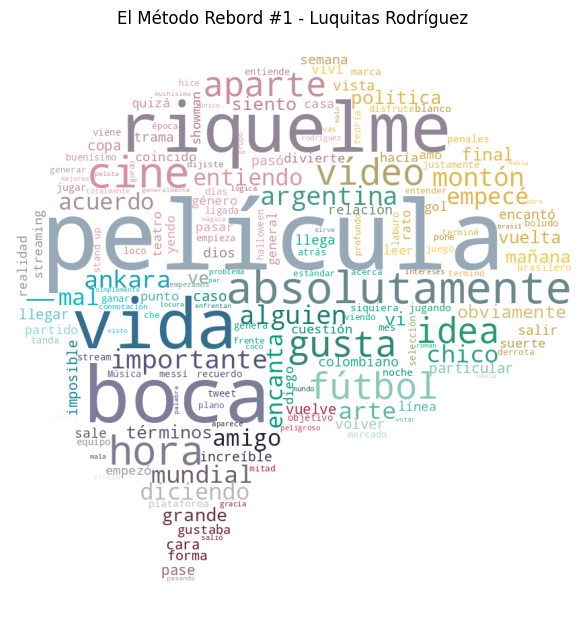

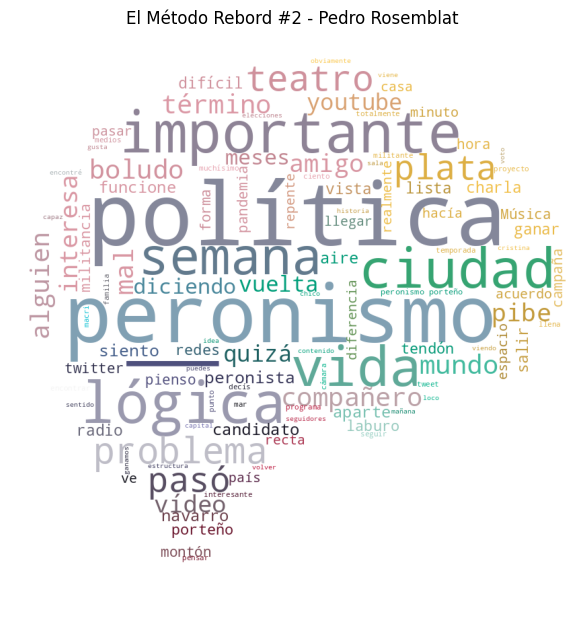

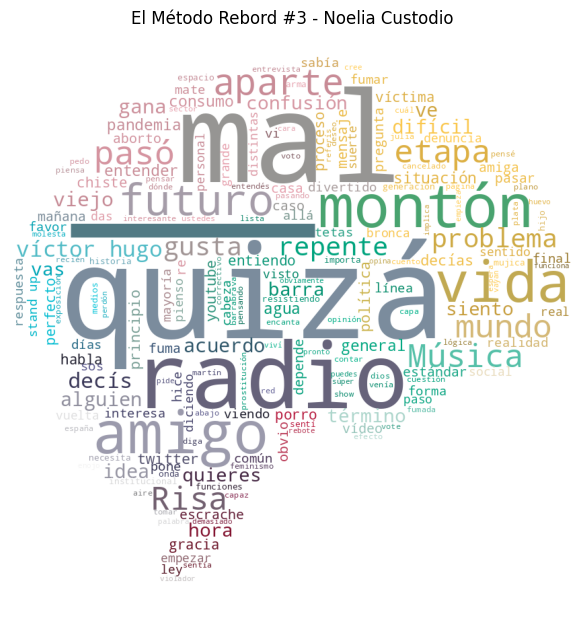

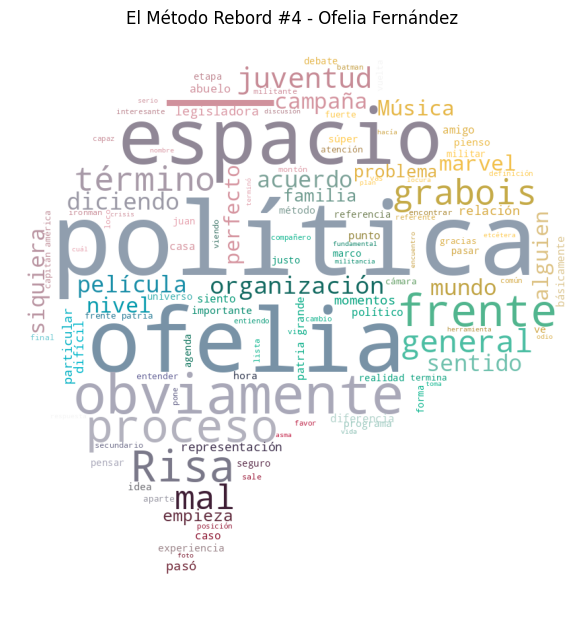

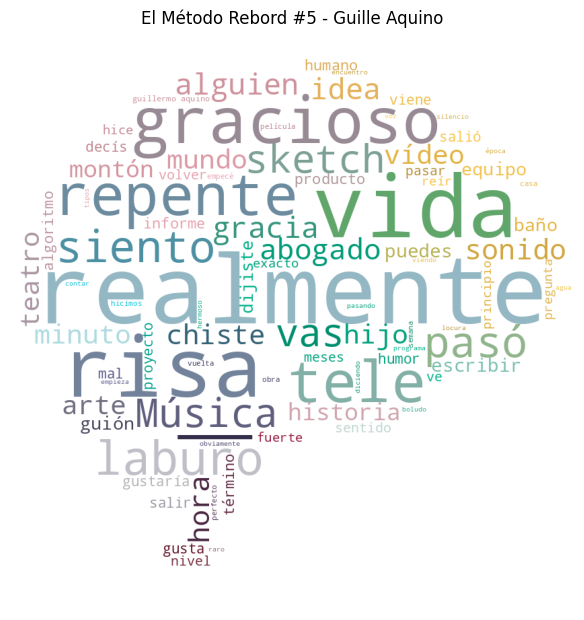

In [17]:
#We will render just the last file
first_5_files = sorted_file_paths[:5]

for file_path in first_5_files:
    file_name = os.path.splitext(os.path.basename(file_path))[0]  # Extract the file name without extension
    with open(file_path, "r") as file:
        text_content = file.read()
    make_cloud(text_content, file_name, stopwords=stopwords, img_url=img_url)

As expected, the main words used are related to the expertise of the interviewed person.

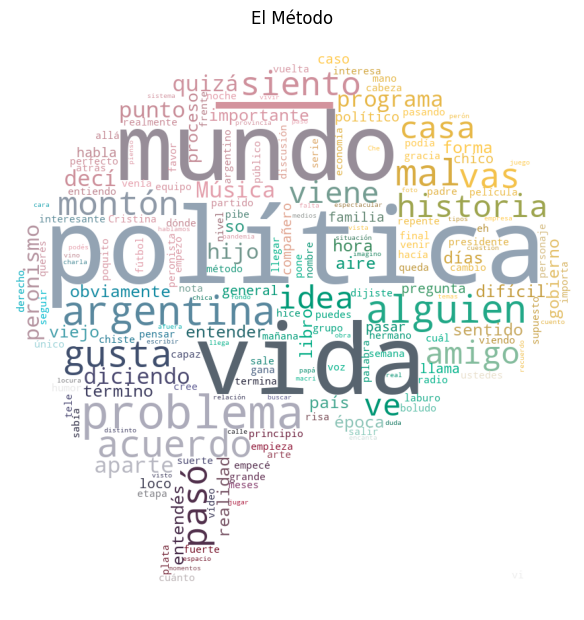

In [13]:
#Getting the WordCloud of all the chapters together
all_texts = ""
for file_path in file_paths:
    with open(file_path, "r") as file:
        text_content = file.read()
    all_texts += text_content + " "

make_cloud(all_texts, "El Método", stopwords=stopwords, img_url=img_url)

"Política"(politics), "mundo" (world), "vida" (life) are the most used words in the program.